In [1]:
# implementation of https://arxiv.org/pdf/1806.07421.pdf

In [2]:
import keras
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Using TensorFlow backend.


In [3]:
h = 7
w = 7
P_1 = 0.5
N_MASKS = 4000
IMAGE_SIZE = (224, 224, 3)

In [4]:
def load_image(path, preprocessing_function=None, target_size=(224, 224)):

    x = keras.preprocessing.image.load_img(path, target_size=target_size)
    x = keras.preprocessing.image.img_to_array(x)

    if preprocessing_function is not None:
        x = preprocessing_function(x)

    return x

# create a random mask
def create_mask(h=7, w=7, H=224, W=224, p_1=0.5, resample=Image.BILINEAR):

    # create random hxw mask
    mask = np.random.choice([0, 1], size=(h, w), p=[1 - p_1, p_1])

    # resize
    mask = Image.fromarray(mask * 255.)
    mask = mask.resize((H + h, W + w), resample=resample)
    mask = np.array(mask)

    # crop to HxW
    w_crop = np.random.randint(0, w + 1)
    h_crop = np.random.randint(0, h + 1)
    mask = mask[h_crop:H + h_crop, w_crop:W + w_crop]

    # normalize
    mask /= np.max(mask)

    return mask


# create a weighted sum of masks
def create_sum_mask(masks, preds_masked, class_index):
    sum_mask = np.zeros(masks[0].shape, dtype=np.float32)

    for i, mask in enumerate(masks):
        m = mask * preds_masked[i, class_index]
        sum_mask += m

    sum_mask -= np.min(sum_mask)
    sum_mask /= np.max(sum_mask)

    return sum_mask

In [5]:
# load pretrained VGG16 model
model = keras.applications.vgg16.VGG16()

In [6]:
INPUT_FILE = './pup-and-kit.jpg'


# generate masked images

img = load_image(
    INPUT_FILE,
    preprocessing_function=keras.applications.vgg16.preprocess_input,
    target_size=IMAGE_SIZE)

X = np.zeros((N_MASKS, ) + IMAGE_SIZE, dtype=np.float32)
masks = np.zeros((N_MASKS, ) + IMAGE_SIZE[:2], dtype=np.float32)

for i in tqdm(range(N_MASKS)):

    m = create_mask(h=h, w=w, H=IMAGE_SIZE[0], W=IMAGE_SIZE[1], p_1=P_1, resample=Image.BILINEAR)
    masks[i] = m
    x = img.copy()
    x[:, :, 0] *= m
    x[:, :, 1] *= m
    x[:, :, 2] *= m
    X[i] = x

100%|██████████| 4000/4000 [00:05<00:00, 722.85it/s]


In [7]:
pred_unmasked = model.predict([[img]])[0]
preds_masked = model.predict(X, verbose=1)

4000/4000 [==============================] - 12s 3ms/step


1  0.27789  Pekinese                 
2  0.12104  Persian_cat              
3  0.10222  Japanese_spaniel         
4  0.08042  Shih-Tzu                 
5  0.03322  Lhasa                    


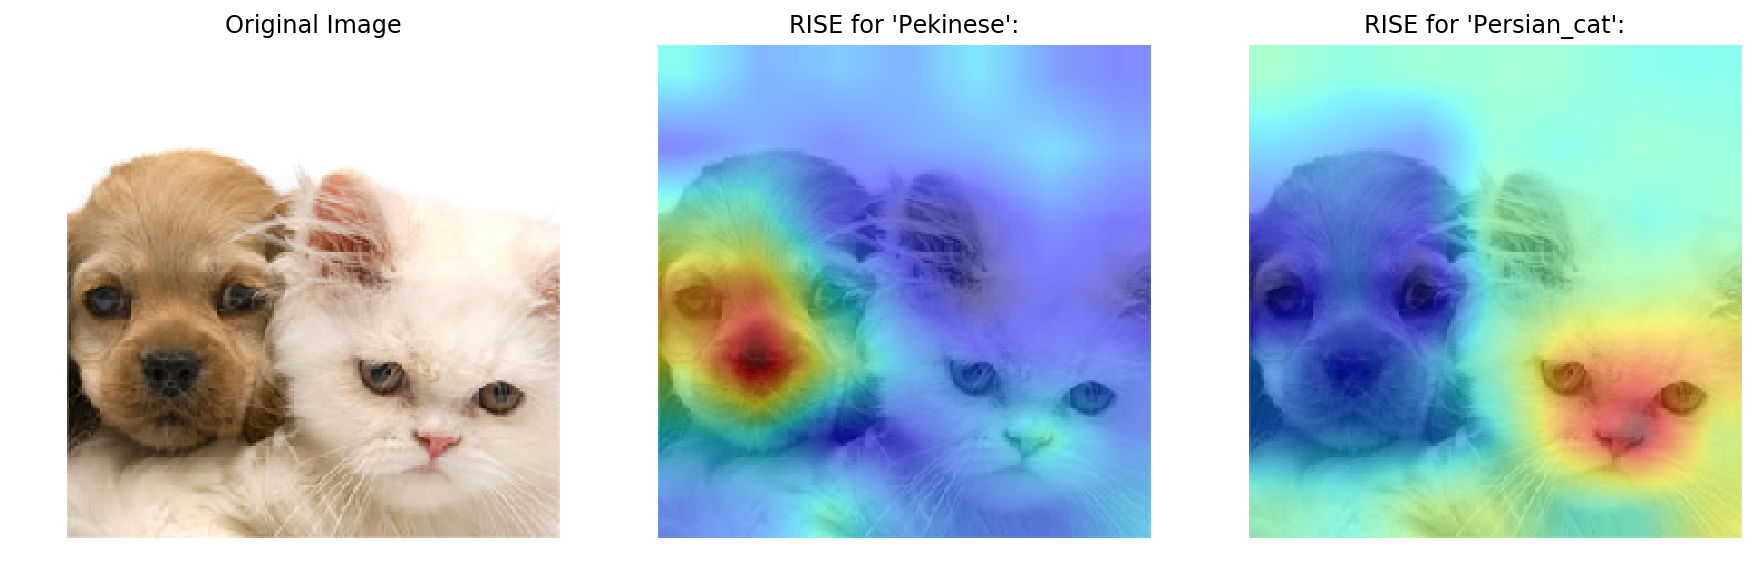

In [8]:
img_orig = load_image(
    INPUT_FILE, preprocessing_function=None,
    target_size=IMAGE_SIZE).astype(np.uint8)


def rgb2gray(rgb):
    r, g, b = rgb[:, :, 0], rgb[:, :, 1], rgb[:, :, 2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray


img_gray = rgb2gray(img_orig)

# print top n predictions
pred_decoded = keras.applications.vgg16.decode_predictions(
    pred_unmasked[np.newaxis, :], top=5)
for i, item in enumerate(pred_decoded[0]):
    print('{:<3}{:<9.5f}{: <25}'.format(1 + i, item[2], item[1]))

    
# display heatmaps

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.title('Original Image')
plt.axis('off')
plt.imshow(img_orig.astype(np.uint8))

#
topn = 1
class_name = pred_decoded[0][topn - 1][1]
class_index = np.argsort(pred_unmasked)[-topn]
sum_mask = create_sum_mask(masks, preds_masked, class_index)

plt.subplot(132)
plt.title('RISE for {!r}:'.format(class_name))
plt.axis('off')
plt.imshow(img_gray, cmap=plt.cm.gray)
plt.imshow(sum_mask, cmap=plt.cm.jet, alpha=0.5)

#
topn = 2
class_name = pred_decoded[0][topn - 1][1]
class_index = np.argsort(pred_unmasked)[-topn]
sum_mask = create_sum_mask(masks, preds_masked, class_index)

plt.subplot(133)
plt.title('RISE for {!r}:'.format(class_name))
plt.axis('off')
plt.imshow(img_gray, cmap=plt.cm.gray)
plt.imshow(sum_mask, cmap=plt.cm.jet, alpha=0.5)

plt.show()